# NAVER 영화리뷰 감성분석

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import L1L2
from keras.initializers import Constant

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

from keras.layers import Bidirectional
%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.5.3
0.6.0
4.3.1


## 1) 데이터 준비와 확인

In [64]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('./data/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [65]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.','..']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 상위 10000개의  단어
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [66]:
index_to_word = {index:word for word, index in word_to_index.items()}
i = 0
for word, index in word_to_index.items():
    print(word, index)
    i += 1
    if i==10:
        break
del i

<PAD> 0
<BOS> 1
<UNK> 2
<UNUSED> 3
영화 4
다 5
고 6
하 7
을 8
보 9


## 2) data loader 구성

In [67]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]
print(get_decoded_sentence(X_train[0], index_to_word)[:45]) #1 번째 리뷰데이터의라벨
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공
모델에 넣어주기 위해서는 pad_sequence를 통해 데이터셋 상의 문장의 길이를 통일해야 한다. 또한 최대 문장의 길이를 정해주기 위하여 데이터셋의 분포를 봐야 한다.

In [68]:
def calc_tokens(x_train, x_test):
    
    total_data_text = list(x_train) + list(x_test)
    num_tokens = [len(tokens) for tokens in total_data_text]
    num_tokens = np.array(num_tokens)

    # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))

    # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print('pad_sequences maxlen : ', maxlen)
    print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
    print('전체 문장의 {}%가 maxlen + 5 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < (max_tokens+5)) / len(num_tokens)))
    print('전체 문장의 {}%가 maxlen + 10 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < (max_tokens+10)) / len(num_tokens)))
    return maxlen
maxlen = calc_tokens(X_train, X_test)

문장길이 평균 :  14.726782670127317
문장길이 최대 :  115
문장길이 표준편차 :  12.039253852722178
pad_sequences maxlen :  38
전체 문장의 0.9339251250390347%가 maxlen 설정값 이내에 포함됩니다. 
전체 문장의 0.9498103297344617%가 maxlen + 5 설정값 이내에 포함됩니다. 
전체 문장의 0.9644976169633304%가 maxlen + 10 설정값 이내에 포함됩니다. 


In [69]:
maxlen = maxlen+10
maxlen

48

In [70]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 48)


## 4) 모델 구성 및 validation set 구성

In [71]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.34, # test/train만큼
                                                  random_state=42)

print(partial_x_train.shape)
print(partial_y_train.shape)

(96480, 48)
(96480,)


In [72]:
x_val.shape, y_val.shape

((49702, 48), (49702,))

In [20]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add((tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))))
model.add(Bidirectional(tf.keras.layers.LSTM(4, return_sequences=True)))
model.add(Bidirectional(tf.keras.layers.LSTM(8)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 8)          2208      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               1088      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 643,585
Trainable params: 643,585
Non-trai

## 5) 모델 train

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
377/377 [==============================] - 32s 63ms/step - loss: 0.4214 - accuracy: 0.8161 - val_loss: 0.3580 - val_accuracy: 0.8448
Epoch 2/10
377/377 [==============================] - 21s 55ms/step - loss: 0.3192 - accuracy: 0.8655 - val_loss: 0.3520 - val_accuracy: 0.8464
Epoch 3/10
377/377 [==============================] - 21s 55ms/step - loss: 0.2917 - accuracy: 0.8791 - val_loss: 0.3512 - val_accuracy: 0.8471
Epoch 4/10
377/377 [==============================] - 24s 63ms/step - loss: 0.2706 - accuracy: 0.8889 - val_loss: 0.3621 - val_accuracy: 0.8478
Epoch 5/10
377/377 [==============================] - 23s 62ms/step - loss: 0.2494 - accuracy: 0.8991 - val_loss: 0.3632 - val_accuracy: 0.8474
Epoch 6/10
377/377 [==============================] - 22s 59ms/step - loss: 0.2283 - accuracy: 0.9076 - val_loss: 0.3817 - val_accuracy: 0.8455
Epoch 7/10
377/377 [==============================] - 22s 58ms/step - loss: 0.2071 - accuracy: 0.9174 - val_loss: 0.4185 - val_accuracy:

In [22]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 10s - loss: 0.5171 - accuracy: 0.8376 - 10s/epoch - 7ms/step


In [23]:
history_dict = history.history

## 6) Loss, Accuracy 그래프 시각화

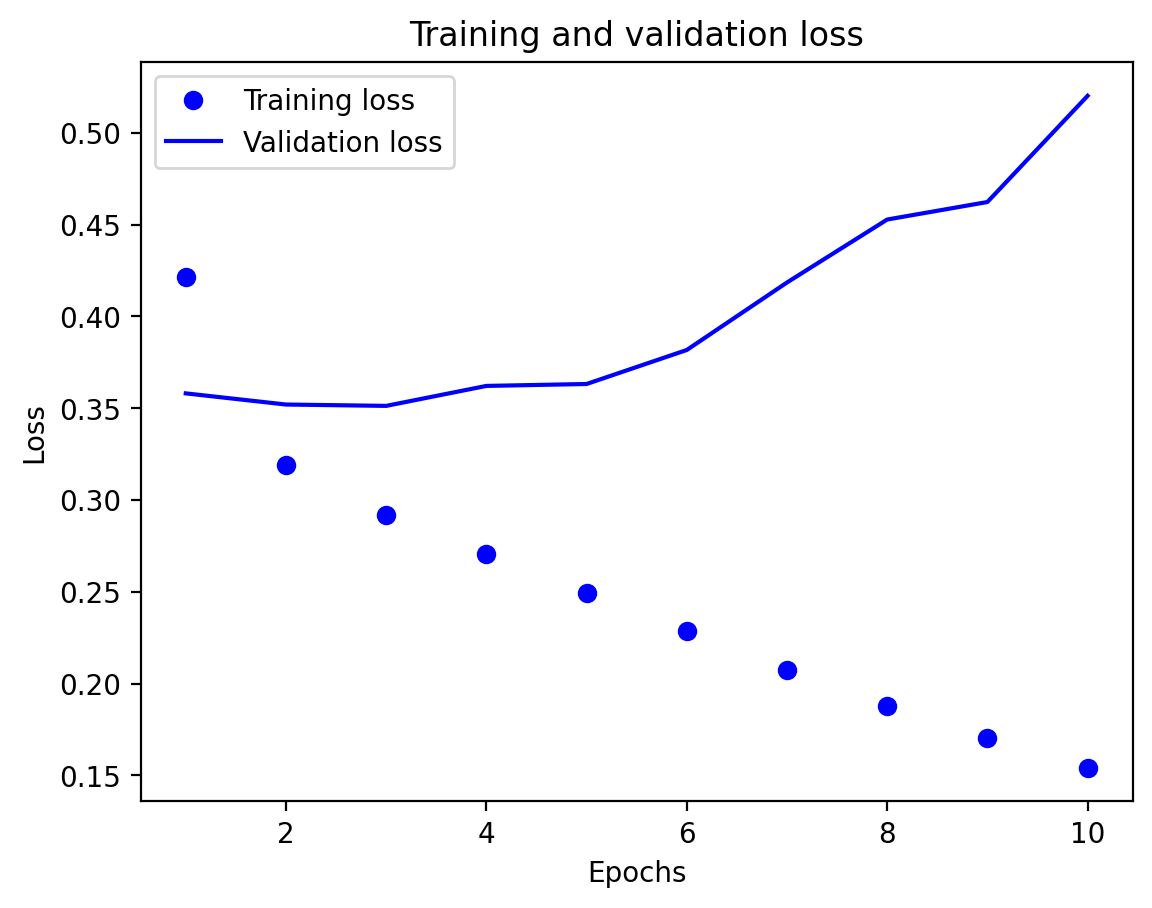

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

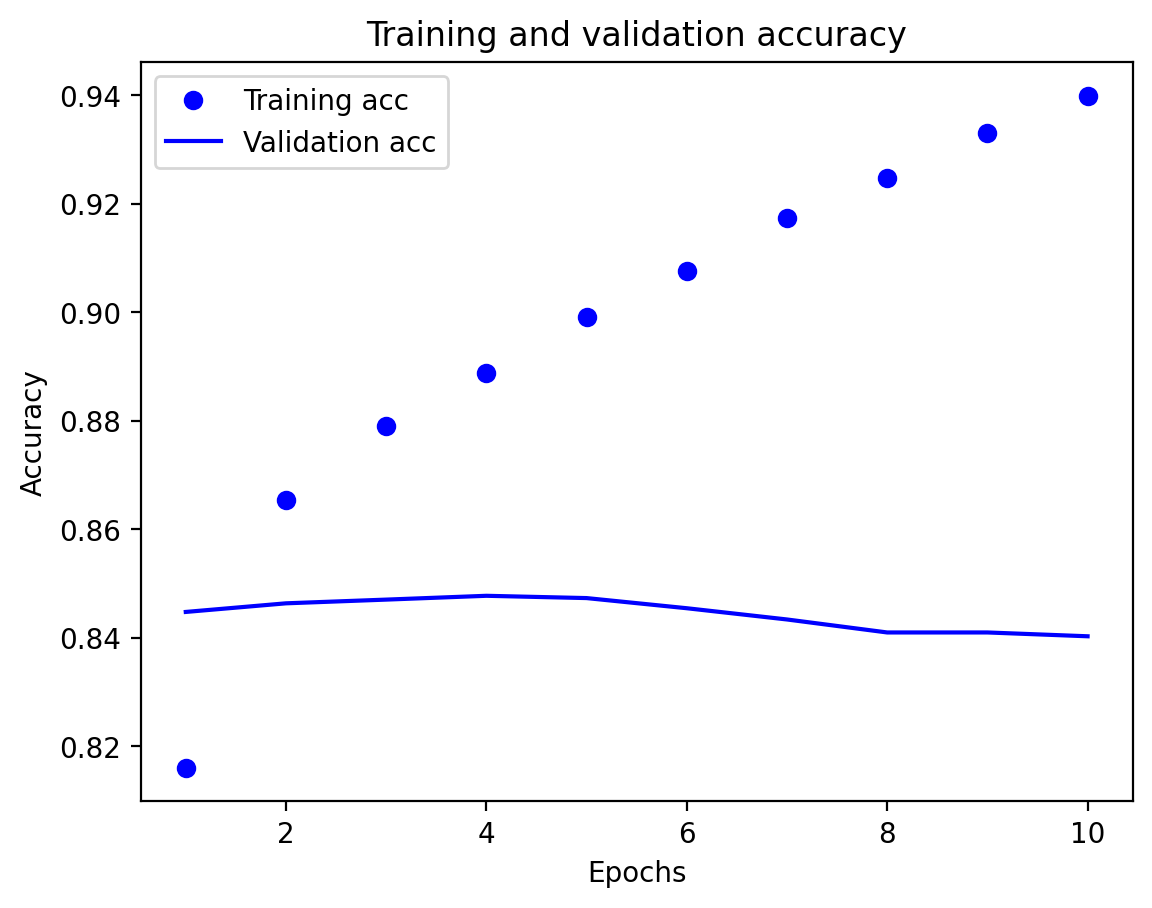

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

overfitting 발생

## 7) 학습된 Embedding layer 분석

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [51]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = r'C:/Users/이정진/Desktop/Aiffel/Exploration/data/sentiment_classification/em.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False, encoding='cp949')
vector = word_vectors['네이버']
vector

array([-0.06218306, -0.02796257, -0.09533077, -0.1793253 , -0.0162764 ,
       -0.02665976, -0.01762366,  0.00923805,  0.00052025, -0.12832761,
        0.03166109, -0.1185839 , -0.04386126,  0.03452627,  0.05940025,
       -0.03140191, -0.03097374,  0.02782954,  0.04080709, -0.02989043,
        0.06444975,  0.18358083, -0.01542605,  0.00054527, -0.02301132,
       -0.0089765 , -0.00467783, -0.0295816 , -0.06931212,  0.05265809,
        0.02150129, -0.13534619, -0.01410006,  0.08338355,  0.01404266,
        0.03894754,  0.01977246,  0.12947518,  0.01627691,  0.01633901,
        0.07867761,  0.13852999,  0.0122012 ,  0.06039672,  0.05481136,
       -0.016867  ,  0.06989955, -0.10575867, -0.02096363,  0.02182583,
       -0.09842868,  0.05409013,  0.05111229, -0.08801669, -0.0012061 ,
       -0.21061634,  0.04506936, -0.03612914, -0.01526183, -0.04463862,
       -0.03976679, -0.04486801,  0.08627407, -0.03399695], dtype=float32)

In [54]:
word_vectors.similar_by_word('사랑')

[('살아가', 0.8955400586128235),
 ('정리', 0.8789567947387695),
 ('깔끔', 0.8738510608673096),
 ('밋', 0.8730262517929077),
 ('데요', 0.8711568117141724),
 ('xx', 0.865044116973877),
 ('바라보', 0.8650079369544983),
 ('자세히', 0.8593778610229492),
 ('눈물', 0.8575814962387085),
 ('멕시코', 0.8568536043167114)]

학습이 잘 된 것 같진 않습니다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

### word vector 불러오기

In [73]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = './data/sentiment_classification/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['사랑']
print(vector.shape)
word_vectors.wv.similar_by_word("사랑")

(100,)


[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [74]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

### 불러온 embedding으로 학습하기

In [85]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(tf.keras.layers.Dropout(0.5))
model.add(Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True))) 
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 48, 100)           1000000   
                                                                 
 dropout_18 (Dropout)        (None, 48, 100)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 48, 16)           6976      
 nal)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 48, 16)            0         
                                                                 
 dense_14 (Dense)            (None, 48, 16)            272       
                                                                 
 dropout_20 (Dropout)        (None, 48, 16)            0         
                                                      

In [86]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train.reshape(-1,1),
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
189/189 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5044

ValueError: in user code:

    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1758, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 48, 1) vs (None,)).


In [ ]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 7s - loss: 0.4890 - accuracy: 0.8199


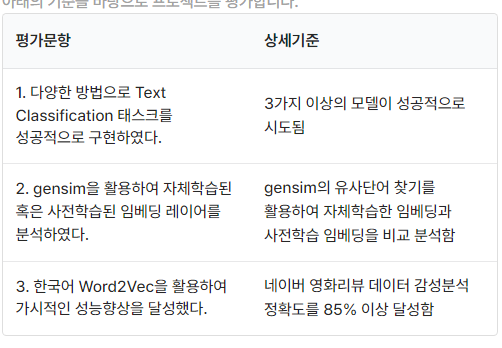